<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span><ul class="toc-item"><li><span><a href="#climate-properties" data-toc-modified-id="climate-properties-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>climate properties</a></span></li><li><span><a href="#wildfire-occurrences" data-toc-modified-id="wildfire-occurrences-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>wildfire occurrences</a></span></li></ul></li></ul></div>

# setup

In [1]:
import datetime
import gc
import json
import os
import pprint
import warnings
from io import BytesIO

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import geopandas as gpd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from folium.plugins import HeatMap
from IPython.display import display
from scipy.interpolate import griddata
from selenium import webdriver
from skimage.transform import resize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [3]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
BRAZIL_EXTENT = [-74, -34, -34, 6]
SAO_PAULO_EXTENT = [-53, -44, -25, -20]

# data

## climate properties

data loading and preprocessing

In [6]:
brazil = gpd.read_file("/home/dusoudeth/Downloads/BR_Pais_2021/BR_Pais_2021.shp")

In [7]:
LAT_LON_SHAPE = (1000, 1000)
# empty_N*5*345*345 tensor
TENSOR = np.empty((0, 5, LAT_LON_SHAPE[0], LAT_LON_SHAPE[1]))
TENSOR_TIMESTAMPS = list()

for _dt in tqdm.tqdm(pd.date_range("2023-08-07", "2023-11-18")):
    try:
        _tensor = list()

        print(_dt)
        # print("      loading num_dias_sem_chuva")
        _file_path = f"../data/01_raw/inpe_queimadas/numero_dias_sem_chuva/INPE_FireRiskModel_2.2_NDWR_{_dt.strftime('%Y%m%d')}.nc"
        _dataset = nc.Dataset(_file_path)
        # print(_dataset.variables.keys()) # dict_keys(['ndsc120', 'time', 'lat', 'lon'])
        # print(_dataset.variables["ndsc120"][:].shape)
        # print(_dataset.variables["time"][:].shape)
        # print(_dataset.variables["lat"][:].shape)
        # print(_dataset.variables["lon"][:].shape)

        # 345x345x1 = lon,lat,ndsc120
        resized_dataset = resize(
            _dataset.variables["ndsc120"][:].data[0],
            LAT_LON_SHAPE,
            anti_aliasing=True,
            mode="constant",
        )
        # print(resized_dataset.shape)
        _tensor.append(resized_dataset)

        # print("      loading precipitacao")
        _file_path = f"../data/01_raw/inpe_queimadas/precipitacao/INPE_FireRiskModel_2.2_Precipitation_{_dt.strftime('%Y%m%d')}.nc"
        _dataset = nc.Dataset(_file_path)
        # print(_dataset.variables.keys()) # dict_keys(['time', 'lon', 'lat', 'prec'])
        # print(_dataset.variables["prec"][:].shape)
        # print(_dataset.variables["time"][:].shape)
        # print(_dataset.variables["lat"][:].shape)
        # print(_dataset.variables["lon"][:].shape)

        # 345x345x1 = lon,lat,prec
        resized_dataset = resize(
            _dataset.variables["prec"][:].data[0],
            LAT_LON_SHAPE,
            anti_aliasing=True,
            mode="constant",
        )
        # print(resized_dataset.shape)
        _tensor.append(resized_dataset)

        # print("      loading risco_fogo")
        _file_path = f"../data/01_raw/inpe_queimadas/risco_fogo/INPE_FireRiskModel_2.2_FireRisk_{_dt.strftime('%Y%m%d')}.nc"
        _dataset = nc.Dataset(_file_path)
        # print(_dataset.variables.keys()) # dict_keys(['time', 'lon', 'lat', 'rf'])
        # print(_dataset.variables["rf"][:].shape)
        # print(_dataset.variables["time"][:].shape)
        # print(_dataset.variables["lat"][:].shape)
        # print(_dataset.variables["lon"][:].shape)

        # 345x345x1 = lon,lat,rf
        resized_dataset = resize(
            _dataset.variables["rf"][:].data[0],
            LAT_LON_SHAPE,
            anti_aliasing=True,
            mode="constant",
        )
        # print(resized_dataset.shape)
        _tensor.append(resized_dataset)


        # print("      loading temperatura")
        _file_path = f"../data/01_raw/inpe_queimadas/temperatura/INPE_FireRiskModel_2.2_Temperature_{_dt.strftime('%Y%m%d')}.nc"
        _dataset = nc.Dataset(_file_path)
        # print(_dataset.variables.keys()) # dict_keys(['time', 'lon', 'lat', 'temp2m'])
        # print(_dataset.variables["temp2m"][:].shape)
        # print(_dataset.variables["time"][:].shape)
        # print(_dataset.variables["lat"][:].shape)
        # print(_dataset.variables["lon"][:].shape)

        # 345x345x1 = lon,lat,temp2m
        resized_dataset = resize(
            _dataset.variables["temp2m"][:].data[0],
            LAT_LON_SHAPE,
            anti_aliasing=True,
            mode="constant",
        )
        # print(resized_dataset.shape)
        _tensor.append(resized_dataset)


        # print("      loading umidade_relativa")
        _file_path = f"../data/01_raw/inpe_queimadas/umidade_relativa/INPE_FireRiskModel_2.2_RelativeHumidity_{_dt.strftime('%Y%m%d')}.nc"
        _dataset = nc.Dataset(_file_path)
        # print(_dataset.variables.keys()) # dict_keys(['time', 'lon', 'lat', 'rh2m'])
        # print(_dataset.variables["rh2m"][:].shape)
        # print(_dataset.variables["time"][:].shape)
        # print(_dataset.variables["lat"][:].shape)
        # print(_dataset.variables["lon"][:].shape)

        # 345x345x1 = lon,lat,rh2m
        resized_dataset = resize(
            _dataset.variables["rh2m"][:].data[0],
            LAT_LON_SHAPE,
            anti_aliasing=True,
            mode="constant",
        )
        # print(resized_dataset.shape)
        _tensor.append(resized_dataset)

        TENSOR = np.append(TENSOR, np.array([_tensor]), axis=0)
        TENSOR_TIMESTAMPS.append(_dt.strftime("%Y-%m-%d"))
    except Exception as e:
        print(e)
        continue


  0%|          | 0/104 [00:00<?, ?it/s]

2023-08-07 00:00:00


  1%|          | 1/104 [00:04<07:37,  4.44s/it]

2023-08-08 00:00:00


  2%|▏         | 2/104 [00:08<07:02,  4.14s/it]

2023-08-09 00:00:00


  3%|▎         | 3/104 [00:11<06:28,  3.84s/it]

2023-08-10 00:00:00


  6%|▌         | 6/104 [00:15<02:53,  1.78s/it]

2023-08-11 00:00:00
[Errno 2] No such file or directory: '../data/01_raw/inpe_queimadas/precipitacao/INPE_FireRiskModel_2.2_Precipitation_20230811.nc'
2023-08-12 00:00:00
[Errno 2] No such file or directory: '../data/01_raw/inpe_queimadas/precipitacao/INPE_FireRiskModel_2.2_Precipitation_20230812.nc'
2023-08-13 00:00:00


  7%|▋         | 7/104 [00:19<03:38,  2.25s/it]

2023-08-14 00:00:00


  8%|▊         | 8/104 [00:23<04:23,  2.75s/it]

2023-08-15 00:00:00


  9%|▊         | 9/104 [00:33<07:44,  4.89s/it]

2023-08-16 00:00:00


 10%|▉         | 10/104 [00:37<07:11,  4.59s/it]

2023-08-17 00:00:00


 11%|█         | 11/104 [00:40<06:38,  4.29s/it]

2023-08-18 00:00:00


 12%|█▏        | 12/104 [00:44<06:15,  4.08s/it]

2023-08-19 00:00:00


 12%|█▎        | 13/104 [00:47<05:57,  3.93s/it]

2023-08-20 00:00:00


 13%|█▎        | 14/104 [00:51<05:43,  3.82s/it]

2023-08-21 00:00:00


 14%|█▍        | 15/104 [00:54<05:33,  3.75s/it]

2023-08-22 00:00:00


 15%|█▌        | 16/104 [00:58<05:27,  3.72s/it]

2023-08-23 00:00:00


 16%|█▋        | 17/104 [01:02<05:20,  3.68s/it]

2023-08-24 00:00:00


 17%|█▋        | 18/104 [01:05<05:16,  3.68s/it]

2023-08-25 00:00:00


 18%|█▊        | 19/104 [01:09<05:11,  3.66s/it]

2023-08-26 00:00:00


 19%|█▉        | 20/104 [01:13<05:07,  3.66s/it]

2023-08-27 00:00:00


 20%|██        | 21/104 [01:16<05:03,  3.66s/it]

2023-08-28 00:00:00


 21%|██        | 22/104 [01:20<04:59,  3.65s/it]

2023-08-29 00:00:00


 22%|██▏       | 23/104 [01:24<04:57,  3.67s/it]

2023-08-30 00:00:00


 23%|██▎       | 24/104 [01:27<04:53,  3.67s/it]

2023-08-31 00:00:00


 24%|██▍       | 25/104 [01:31<04:49,  3.66s/it]

2023-09-01 00:00:00


 25%|██▌       | 26/104 [01:35<04:45,  3.66s/it]

2023-09-02 00:00:00


 26%|██▌       | 27/104 [01:38<04:41,  3.65s/it]

2023-09-03 00:00:00


 27%|██▋       | 28/104 [01:42<04:37,  3.66s/it]

2023-09-04 00:00:00


 28%|██▊       | 29/104 [01:46<04:35,  3.67s/it]

2023-09-05 00:00:00


 29%|██▉       | 30/104 [01:49<04:32,  3.68s/it]

2023-09-06 00:00:00


 30%|██▉       | 31/104 [01:53<04:29,  3.70s/it]

2023-09-07 00:00:00


 31%|███       | 32/104 [01:57<04:26,  3.70s/it]

2023-09-08 00:00:00


 32%|███▏      | 33/104 [02:01<04:24,  3.72s/it]

2023-09-09 00:00:00


 33%|███▎      | 34/104 [02:04<04:21,  3.73s/it]

2023-09-10 00:00:00


 34%|███▎      | 35/104 [02:08<04:17,  3.73s/it]

2023-09-11 00:00:00


 35%|███▍      | 36/104 [02:12<04:13,  3.72s/it]

2023-09-12 00:00:00


 36%|███▌      | 37/104 [02:16<04:10,  3.74s/it]

2023-09-13 00:00:00


 37%|███▋      | 38/104 [02:19<04:07,  3.76s/it]

2023-09-14 00:00:00


 38%|███▊      | 39/104 [02:23<04:04,  3.77s/it]

2023-09-15 00:00:00


 38%|███▊      | 40/104 [02:27<04:01,  3.77s/it]

2023-09-16 00:00:00


 39%|███▉      | 41/104 [02:31<03:56,  3.76s/it]

2023-09-17 00:00:00


 40%|████      | 42/104 [02:34<03:54,  3.78s/it]

2023-09-18 00:00:00


 41%|████▏     | 43/104 [02:38<03:52,  3.81s/it]

2023-09-19 00:00:00


 42%|████▏     | 44/104 [02:42<03:48,  3.80s/it]

2023-09-20 00:00:00


 43%|████▎     | 45/104 [02:46<03:44,  3.80s/it]

2023-09-21 00:00:00


 44%|████▍     | 46/104 [02:50<03:41,  3.81s/it]

2023-09-22 00:00:00


 45%|████▌     | 47/104 [02:54<03:37,  3.82s/it]

2023-09-23 00:00:00


 46%|████▌     | 48/104 [02:57<03:33,  3.81s/it]

2023-09-24 00:00:00


 47%|████▋     | 49/104 [03:01<03:29,  3.81s/it]

2023-09-25 00:00:00


 48%|████▊     | 50/104 [03:05<03:26,  3.82s/it]

2023-09-26 00:00:00


 49%|████▉     | 51/104 [03:09<03:24,  3.86s/it]

2023-09-27 00:00:00


 50%|█████     | 52/104 [03:13<03:21,  3.88s/it]

2023-09-28 00:00:00


 51%|█████     | 53/104 [03:17<03:17,  3.87s/it]

2023-09-29 00:00:00


 52%|█████▏    | 54/104 [03:21<03:13,  3.87s/it]

2023-09-30 00:00:00


 53%|█████▎    | 55/104 [03:25<03:09,  3.88s/it]

2023-10-01 00:00:00


 54%|█████▍    | 56/104 [03:28<03:06,  3.89s/it]

2023-10-02 00:00:00


 55%|█████▍    | 57/104 [03:32<03:02,  3.89s/it]

2023-10-03 00:00:00


 56%|█████▌    | 58/104 [03:36<02:59,  3.91s/it]

2023-10-04 00:00:00


 57%|█████▋    | 59/104 [03:40<02:56,  3.91s/it]

2023-10-05 00:00:00


 58%|█████▊    | 60/104 [03:44<02:53,  3.94s/it]

2023-10-06 00:00:00


 59%|█████▊    | 61/104 [03:48<02:49,  3.95s/it]

2023-10-07 00:00:00


 60%|█████▉    | 62/104 [03:52<02:46,  3.96s/it]

2023-10-08 00:00:00


 61%|██████    | 63/104 [03:56<02:42,  3.95s/it]

2023-10-09 00:00:00


 62%|██████▏   | 64/104 [04:00<02:38,  3.97s/it]

2023-10-10 00:00:00


 62%|██████▎   | 65/104 [04:04<02:34,  3.97s/it]

2023-10-11 00:00:00


 63%|██████▎   | 66/104 [04:08<02:31,  3.99s/it]

2023-10-12 00:00:00


 64%|██████▍   | 67/104 [04:12<02:27,  3.99s/it]

2023-10-13 00:00:00


 65%|██████▌   | 68/104 [04:16<02:24,  4.01s/it]

2023-10-14 00:00:00


 66%|██████▋   | 69/104 [04:20<02:20,  4.03s/it]

2023-10-15 00:00:00


 67%|██████▋   | 70/104 [04:24<02:16,  4.03s/it]

2023-10-16 00:00:00


 68%|██████▊   | 71/104 [04:28<02:13,  4.04s/it]

2023-10-17 00:00:00


 69%|██████▉   | 72/104 [04:32<02:09,  4.05s/it]

2023-10-18 00:00:00


 70%|███████   | 73/104 [04:36<02:05,  4.03s/it]

2023-10-19 00:00:00


 71%|███████   | 74/104 [04:41<02:01,  4.06s/it]

2023-10-20 00:00:00


 72%|███████▏  | 75/104 [04:45<01:57,  4.06s/it]

2023-10-21 00:00:00


 73%|███████▎  | 76/104 [04:49<01:53,  4.05s/it]

2023-10-22 00:00:00


 74%|███████▍  | 77/104 [04:53<01:50,  4.08s/it]

2023-10-23 00:00:00


 75%|███████▌  | 78/104 [04:57<01:49,  4.21s/it]

2023-10-24 00:00:00


 76%|███████▌  | 79/104 [05:01<01:44,  4.19s/it]

2023-10-25 00:00:00


 77%|███████▋  | 80/104 [05:06<01:40,  4.17s/it]

2023-10-26 00:00:00


 78%|███████▊  | 81/104 [05:10<01:35,  4.16s/it]

2023-10-27 00:00:00


 79%|███████▉  | 82/104 [05:14<01:31,  4.14s/it]

2023-10-28 00:00:00


 80%|███████▉  | 83/104 [05:18<01:26,  4.14s/it]

2023-10-29 00:00:00


 81%|████████  | 84/104 [05:22<01:22,  4.12s/it]

2023-10-30 00:00:00


 82%|████████▏ | 85/104 [05:26<01:18,  4.11s/it]

2023-10-31 00:00:00


 83%|████████▎ | 86/104 [05:30<01:13,  4.11s/it]

2023-11-01 00:00:00


 84%|████████▎ | 87/104 [05:34<01:09,  4.11s/it]

2023-11-02 00:00:00


 85%|████████▍ | 88/104 [05:39<01:06,  4.17s/it]

2023-11-03 00:00:00


 86%|████████▌ | 89/104 [05:43<01:02,  4.18s/it]

2023-11-04 00:00:00


 87%|████████▋ | 90/104 [05:47<00:58,  4.19s/it]

2023-11-05 00:00:00


 88%|████████▊ | 91/104 [05:51<00:54,  4.21s/it]

2023-11-06 00:00:00


 88%|████████▊ | 92/104 [05:55<00:50,  4.21s/it]

2023-11-07 00:00:00


 89%|████████▉ | 93/104 [06:00<00:46,  4.19s/it]

2023-11-08 00:00:00


 90%|█████████ | 94/104 [06:04<00:42,  4.20s/it]

2023-11-09 00:00:00


 91%|█████████▏| 95/104 [06:08<00:37,  4.19s/it]

2023-11-10 00:00:00


 92%|█████████▏| 96/104 [06:12<00:33,  4.20s/it]

2023-11-11 00:00:00


 93%|█████████▎| 97/104 [06:16<00:29,  4.20s/it]

2023-11-12 00:00:00


 94%|█████████▍| 98/104 [06:21<00:25,  4.21s/it]

2023-11-13 00:00:00


 95%|█████████▌| 99/104 [06:25<00:21,  4.21s/it]

2023-11-14 00:00:00


 96%|█████████▌| 100/104 [06:29<00:16,  4.22s/it]

2023-11-15 00:00:00


 97%|█████████▋| 101/104 [06:33<00:12,  4.23s/it]

2023-11-16 00:00:00


 98%|█████████▊| 102/104 [06:38<00:08,  4.25s/it]

2023-11-17 00:00:00


 99%|█████████▉| 103/104 [06:42<00:04,  4.26s/it]

2023-11-18 00:00:00


100%|██████████| 104/104 [06:47<00:00,  3.91s/it]


In [8]:
gc.collect()

70

In [9]:
TENSOR.shape

(102, 5, 1000, 1000)

In [10]:
# convert to numpy tensor
TENSOR = np.array(TENSOR)
print(TENSOR.shape)

save_data_path = f"../data/02_intermediate/{experiment_name}"

# save as hdf5 using TENSOR_TIMESTAMPS as keys
with h5py.File(f"{save_data_path}/timeseries_normed_tensor.h5", "w") as f:
    for i, _timestamp in enumerate(TENSOR_TIMESTAMPS):
        f.create_dataset(_timestamp, data=TENSOR[i])


(102, 5, 1000, 1000)


check if the data is already in the correct format

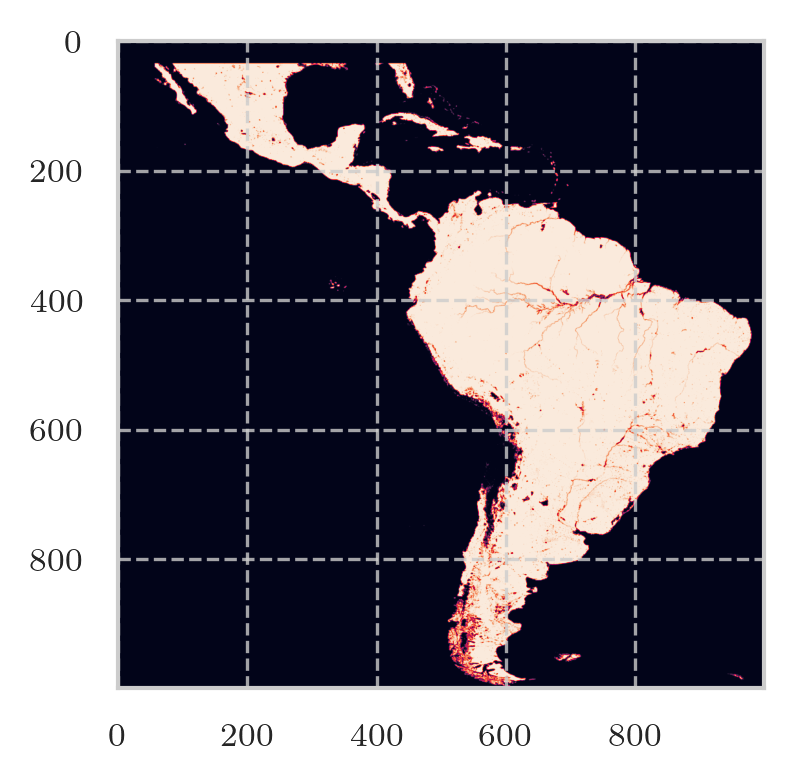

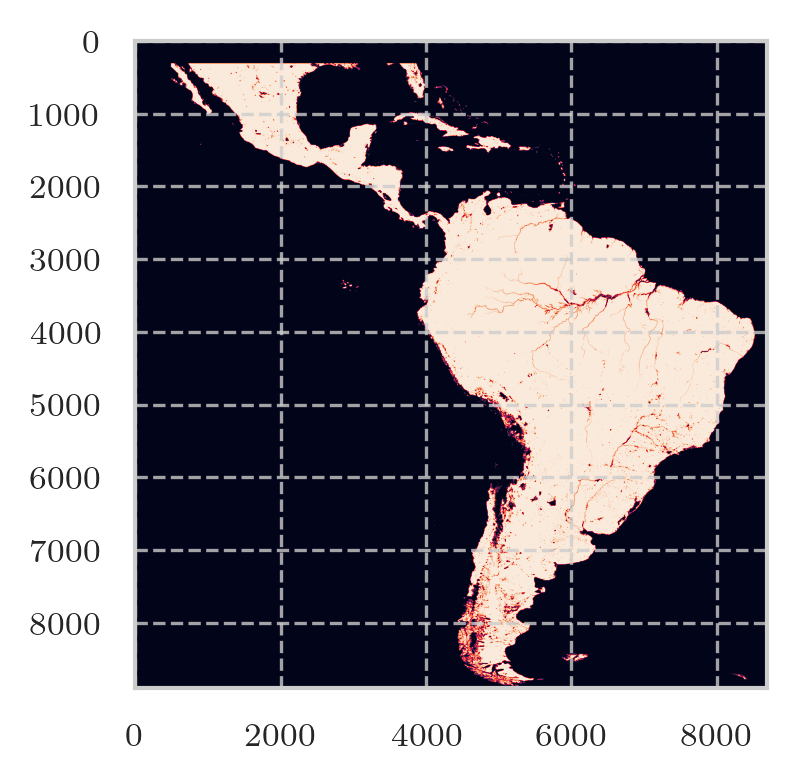

In [8]:
# read hdf5
with h5py.File(f"../data/02_intermediate/wildfire_spread/timeseries_normed_tensor.h5", "r") as f:
    df = f["2023-08-15"][2]
    df = np.flipud(df)
    fig, ax = plt.subplots()
    ax.imshow(df)
    
# read equivalent netcdf
_file_path = f"../data/01_raw/inpe_queimadas/risco_fogo/INPE_FireRiskModel_2.2_FireRisk_20230815.nc"
df = nc.Dataset(_file_path)
fig, ax = plt.subplots()
ax.imshow(np.flipud(df.variables["rf"][:].data[0]))

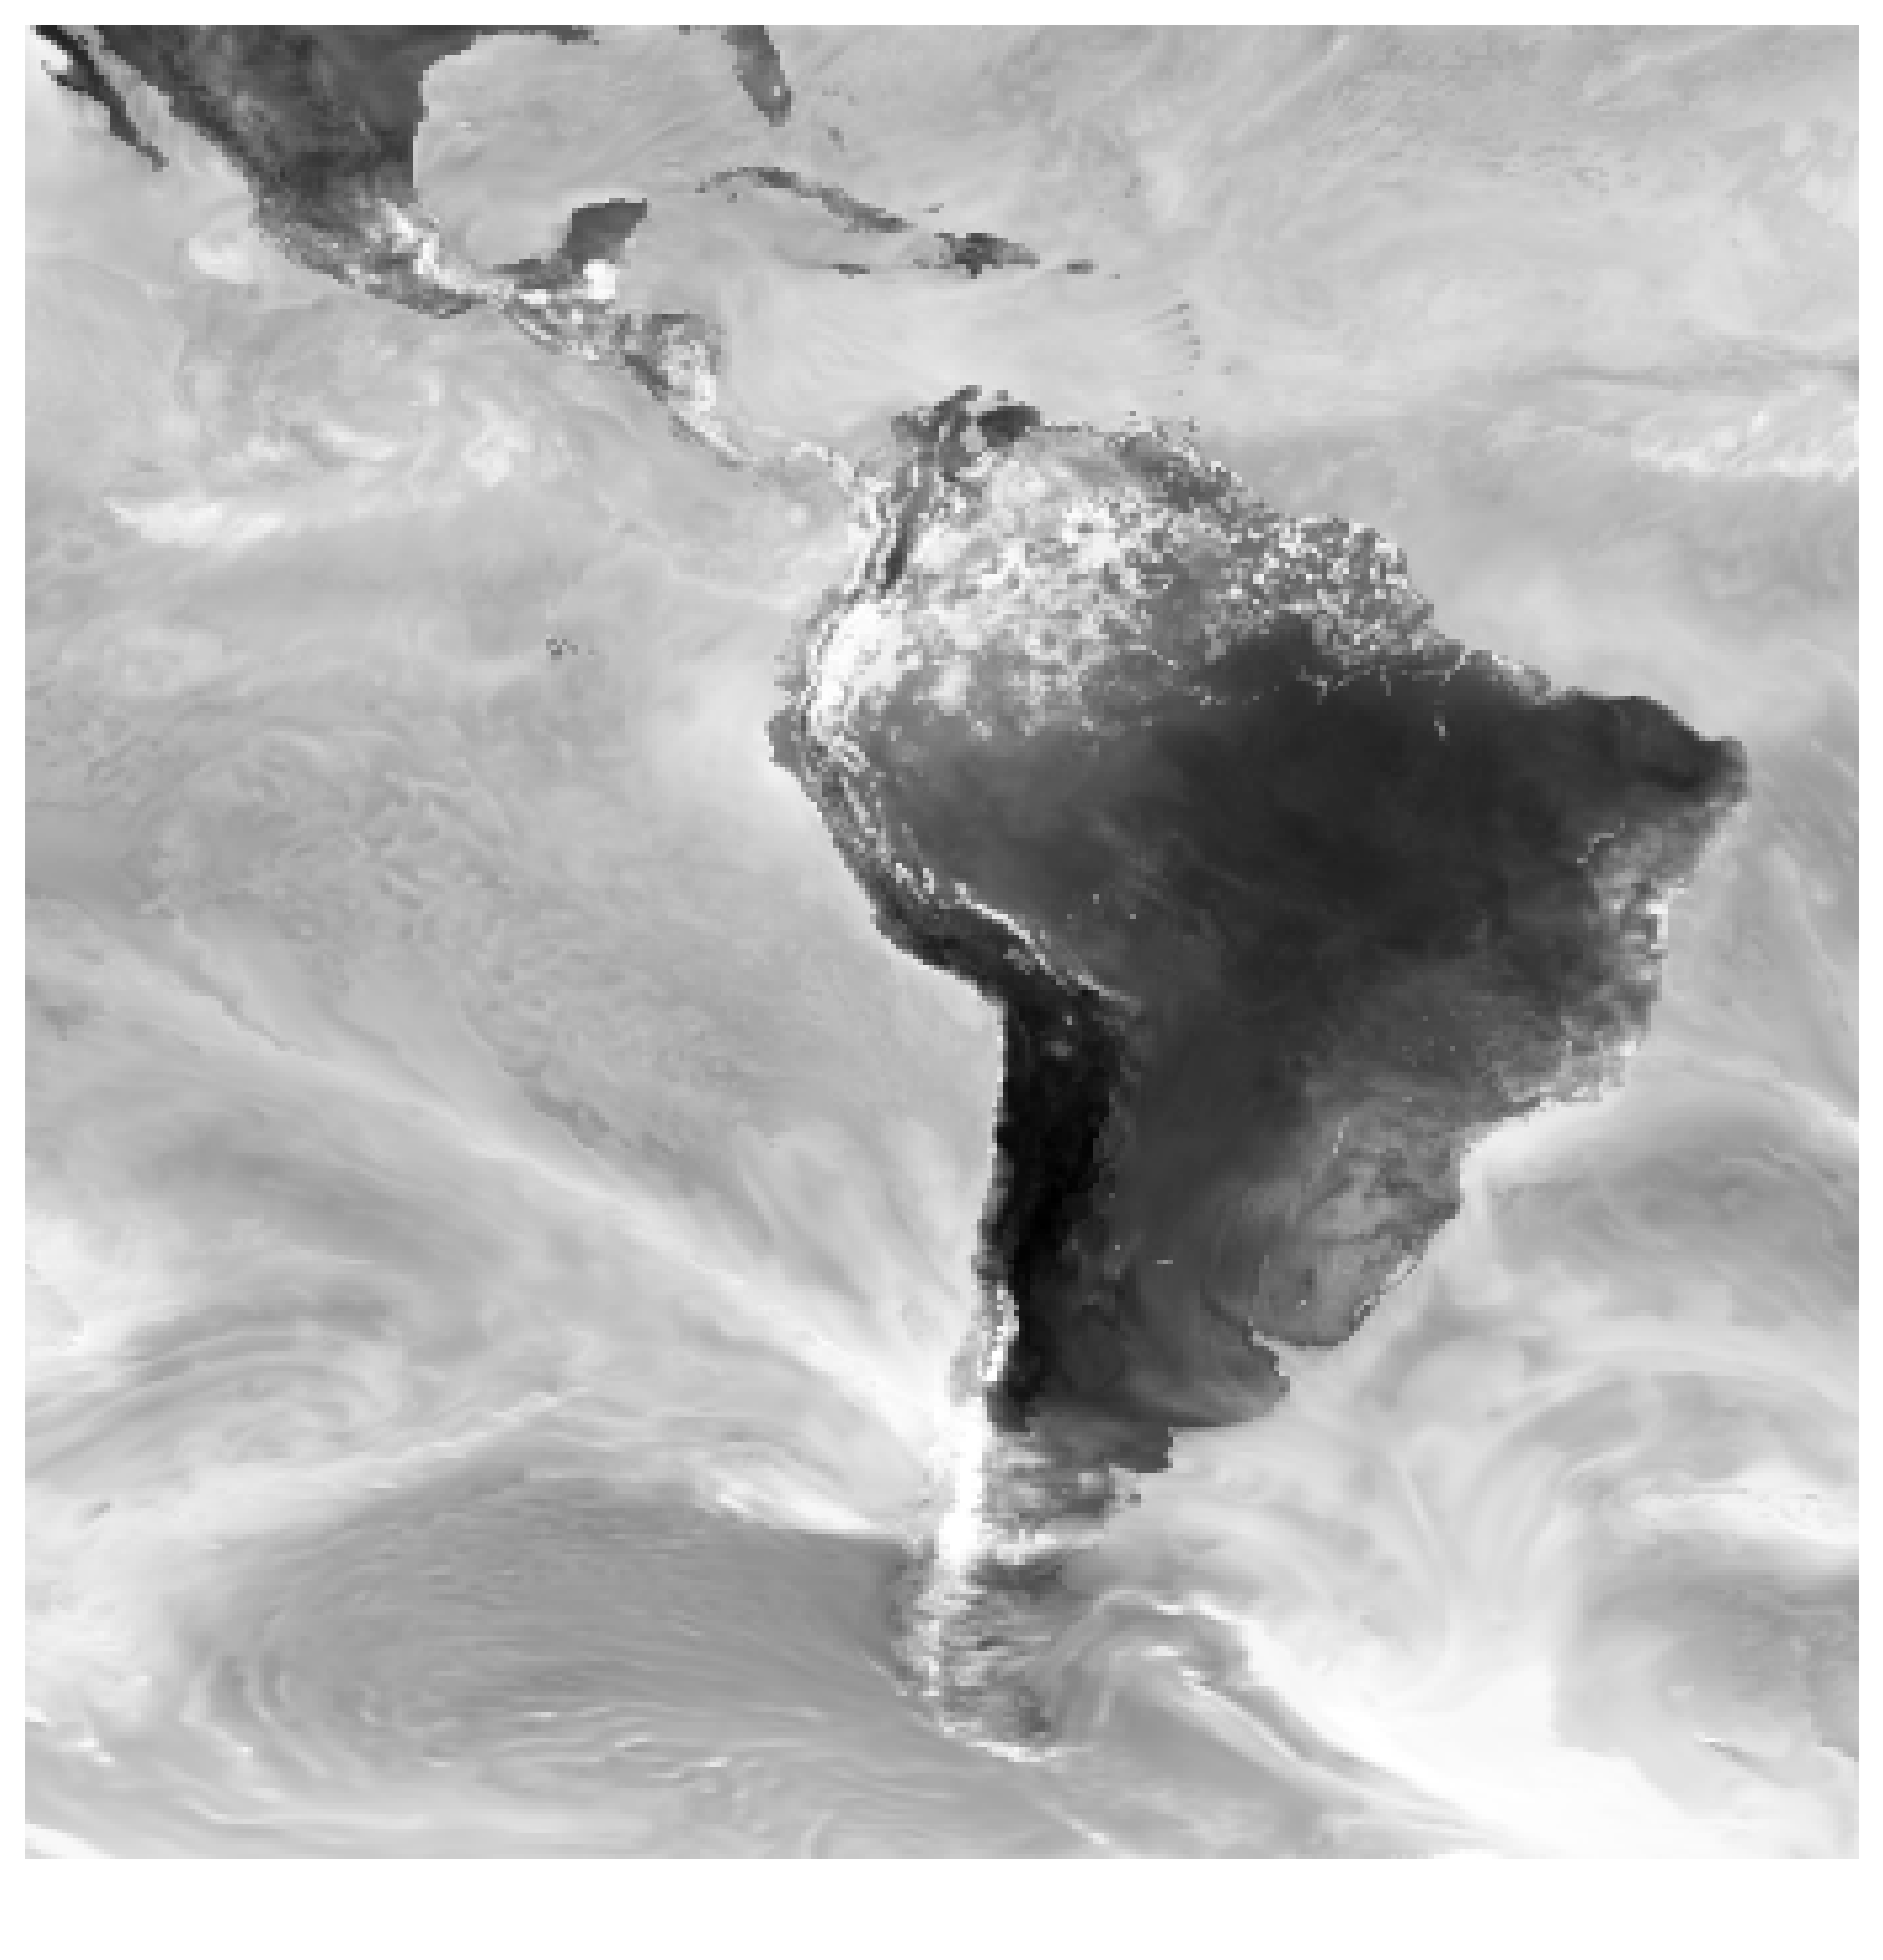

In [49]:
# read equivalent netcdf and use grayscale colormap
_file_path = f"../data/01_raw/inpe_queimadas/umidade_relativa/INPE_FireRiskModel_2.2_RelativeHumidity_20230815.nc"
df = nc.Dataset(_file_path)
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), frameon=False)
ax.set_extent(BRAZIL_EXTENT)

ax.imshow(
    np.flipud(df.variables["rh2m"][:].data[0]),
    origin="upper",
    extent=BRAZIL_EXTENT,
    transform=ccrs.PlateCarree(),
    cmap="gray",
)

fig.canvas.draw()

data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

gray_data = np.dot(data[...,:3], [0.2989, 0.5870, 0.1140])

gray_data_normalized = gray_data / 255.0


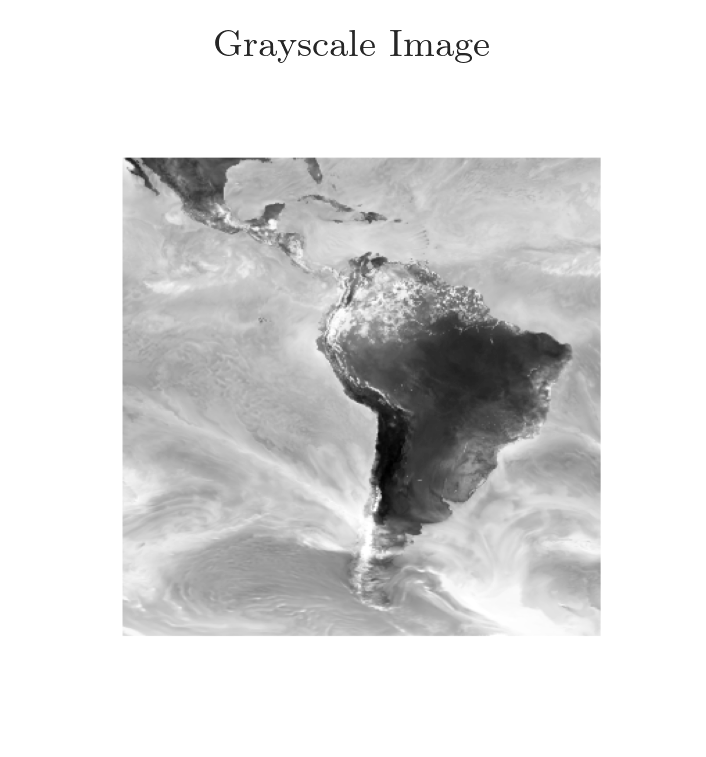

In [51]:
fig, ax = plt.subplots()
plt.imshow(gray_data_normalized, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')  # To turn off the axis
plt.show()

In [25]:
print(np.flipud(df.variables["rh2m"][:].data[0]).shape)

print(df.variables["lon"][:].data.shape)

print(df.variables["lat"][:].data.shape)

(361, 345)
(345,)
(361,)


## wildfire occurrences

In [17]:
# get max,min lat,lon for netcdf files
_file_path = f"../data/01_raw/inpe_queimadas/risco_fogo/INPE_FireRiskModel_2.2_FireRisk_20230815.nc"
df = nc.Dataset(_file_path)
print(df.variables["lat"][:].data.max())
print(df.variables["lat"][:].data.min())
print(df.variables["lon"][:].data.max())
print(df.variables["lon"][:].data.min())

MAX_LAT = df.variables["lat"][:].data.max()
MIN_LAT = df.variables["lat"][:].data.min()
MAX_LON = df.variables["lon"][:].data.max()
MIN_LON = df.variables["lon"][:].data.min()


32.99499999641088
-55.98500000358912
-33.009801806103724
-119.98980180610373


In [102]:
DF = pd.DataFrame()

for _dt in tqdm.tqdm(pd.date_range("2023-08-07", "2023-11-18")):
    try:
        _tensor = list()

        print(_dt)

        _dataset = pd.read_csv(f"../data/01_raw/inpe_queimadas/focos/focos_diario_br_{_dt.strftime('%Y%m%d')}.csv")
        if _dataset.query("risco_fogo > 0").shape[0] > 0:
            DF = pd.concat([DF, _dataset.query("risco_fogo == 1")])
        
    except Exception as e:
        continue

 72%|███████▏  | 75/104 [00:00<00:00, 509.04it/s]

2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00
2023-08-11 00:00:00
2023-08-12 00:00:00
2023-08-13 00:00:00
2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00
2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00
2023-08-26 00:00:00
2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00
2023-09-19 00:00:00
2023-09-20 00:00:00
2023-09-21 00:00:00
2023-09-22 00:00:00
2023-09-23 00:00:00
2023-09-24 00:00:00
2023-09-25 00:00:00


100%|██████████| 104/104 [00:01<00:00, 57.95it/s]

2023-11-18 00:00:00


In [103]:
DF.head()

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
2,9aeff646-f3d9-3ba5-bb27-2fbd49ce31db,-4.9400,-44.1700,2023-10-31 00:04:57,MSG-03,GOVERNADOR ARCHER,MARANHÃO,Brasil,2104503,21,33,7.0,0.0,1.0,Cerrado,NaN
3,3ff528c4-e654-32ca-85ce-d8210bd89052,-4.9100,-44.1700,2023-10-31 00:04:57,MSG-03,CODÓ,MARANHÃO,Brasil,2103307,21,33,7.0,0.0,1.0,Cerrado,NaN
19,35cc0e7a-0dd0-33db-95a8-cb7192a1a113,-3.2584,-49.1854,2023-10-31 00:05:24,GOES-16,MOJU,PARÁ,Brasil,1504703,15,33,7.0,0.0,1.0,Amazônia,118.1
23,a12ea5e7-39f3-38f0-aaab-621042026732,-3.2399,-49.1860,2023-10-31 00:05:24,GOES-16,MOJU,PARÁ,Brasil,1504703,15,33,8.0,0.0,1.0,Amazônia,220.4
29,bc9e9e48-7659-34a8-ba07-bbea02eda671,-3.8021,-47.7887,2023-10-31 00:05:27,GOES-16,ULIANÓPOLIS,PARÁ,Brasil,1508126,15,33,11.0,0.0,1.0,Amazônia,276.8


In [105]:
display( DF['risco_fogo'].value_counts() )

display( pd.to_datetime(DF["data_hora_gmt"]).dt.strftime("%Y-%m-%d").value_counts() )

risco_fogo
1.0    144477
Name: count, dtype: int64

data_hora_gmt
2023-11-13    15070
2023-11-14    13403
2023-11-15    11228
2023-11-17    11227
2023-11-12    10984
2023-10-31    10009
2023-11-01     9139
2023-11-10     9055
2023-11-16     8669
2023-11-11     8485
2023-11-09     7213
2023-11-18     7092
2023-11-04     6454
2023-11-02     6189
2023-11-03     5392
2023-11-05     4868
Name: count, dtype: int64

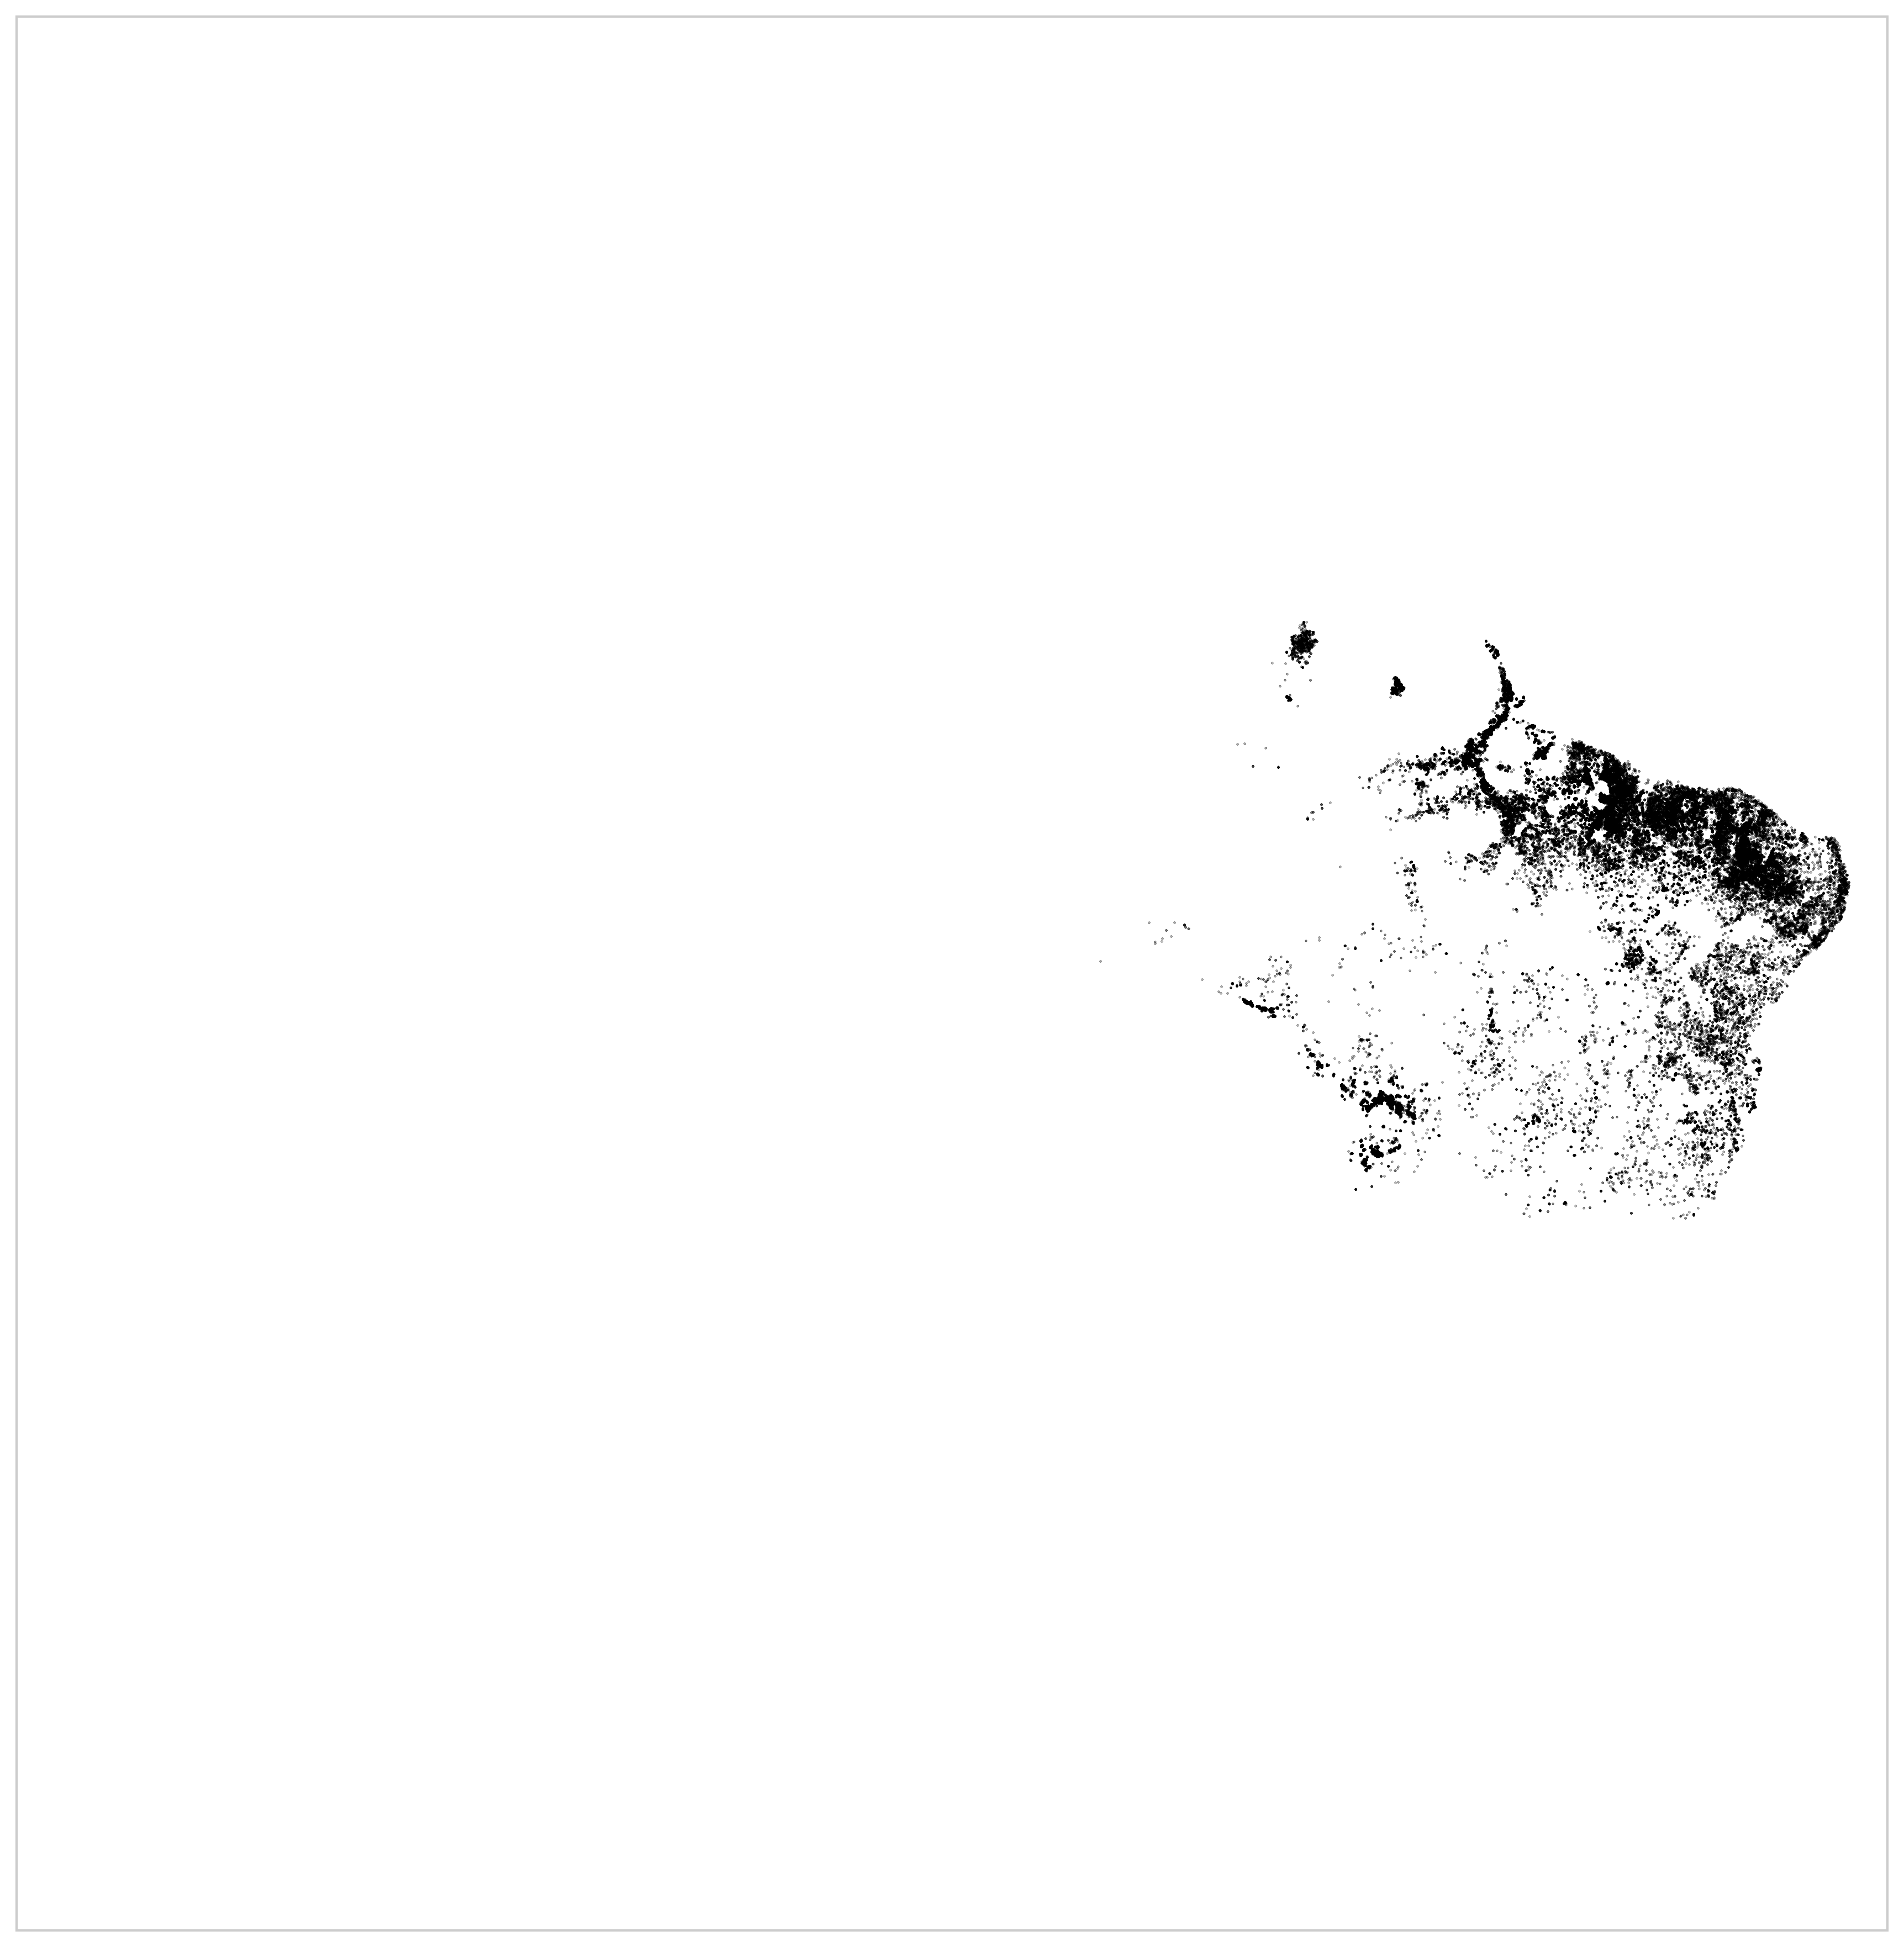

In [127]:
# generate cartopy scatter plot with MAX,MIN LAT,LON boundaries and then convert it to numpy array
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(
    [MIN_LON, MAX_LON, MIN_LAT, MAX_LAT],
    crs=ccrs.PlateCarree(),
)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)

ax.scatter(
    DF.query("risco_fogo == 1")["lon"],
    DF.query("risco_fogo == 1")["lat"],
    transform=ccrs.PlateCarree(),
    marker='.',
    s=0.1,
    color="black",
)

fig.canvas.draw()

# convert matplotlib figure to numpy binary array
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# mean of RGB channels
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,)).mean(axis=2)
# binary array
data = np.where(data == 255, 0, 1)

In [128]:
data.shape 

(4500, 4500)

In [129]:
DF

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
2,9aeff646-f3d9-3ba5-bb27-2fbd49ce31db,-4.9400,-44.1700,2023-10-31 00:04:57,MSG-03,GOVERNADOR ARCHER,MARANHÃO,Brasil,2104503,21,33,7.0,0.0,1.0,Cerrado,NaN
3,3ff528c4-e654-32ca-85ce-d8210bd89052,-4.9100,-44.1700,2023-10-31 00:04:57,MSG-03,CODÓ,MARANHÃO,Brasil,2103307,21,33,7.0,0.0,1.0,Cerrado,NaN
19,35cc0e7a-0dd0-33db-95a8-cb7192a1a113,-3.2584,-49.1854,2023-10-31 00:05:24,GOES-16,MOJU,PARÁ,Brasil,1504703,15,33,7.0,0.0,1.0,Amazônia,118.1
23,a12ea5e7-39f3-38f0-aaab-621042026732,-3.2399,-49.1860,2023-10-31 00:05:24,GOES-16,MOJU,PARÁ,Brasil,1504703,15,33,8.0,0.0,1.0,Amazônia,220.4
29,bc9e9e48-7659-34a8-ba07-bbea02eda671,-3.8021,-47.7887,2023-10-31 00:05:27,GOES-16,ULIANÓPOLIS,PARÁ,Brasil,1508126,15,33,11.0,0.0,1.0,Amazônia,276.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31025,557d2aa4-e9cd-300e-806c-548b5b72436c,-17.5678,-57.5146,2023-11-18 23:46:45,GOES-16,POCONÉ,MATO GROSSO,Brasil,5106505,51,33,8.0,0.5,1.0,Pantanal,56.2
31037,e534aaa5-5a2f-3a28-8111-dd5c3f9e12bf,-19.6418,-56.9569,2023-11-18 23:46:56,GOES-16,AQUIDAUANA,MATO GROSSO DO SUL,Brasil,5001102,50,33,9.0,0.0,1.0,Pantanal,99.0
31042,7dd13b19-056c-3e43-ae31-d2096ff2e774,-19.7218,-56.9667,2023-11-18 23:46:56,GOES-16,MIRANDA,MATO GROSSO DO SUL,Brasil,5005608,50,33,7.0,0.0,1.0,Pantanal,125.3
31045,9e659c88-0ccc-3cb7-a815-6811e3632508,-19.6816,-56.9723,2023-11-18 23:46:56,GOES-16,AQUIDAUANA,MATO GROSSO DO SUL,Brasil,5001102,50,33,6.0,0.0,1.0,Pantanal,90.0
